# Project for 42186 Model-based Machine Learning F21  

## PGM in Intrusion Detection System

### Notebook - GMM (K=5)-hyperprior

The KDDCUP99 10 percent dataset from the UCI repository. [1] It is a benchmark dataset for the evaluation of network Intrusion Detection System including the records of normal and malicious traffics. It contains 494021 samples in total with 42 dimensions. 

The target for this project is to consider it as a classification problem without time as parameter. This notebook studies how to do a fine-grained detection to classify the data samples into normal or 4 type of attacks by running GMM as an unsupervised learning model to get a intrusion detection result. Based on the GMM (K=5) notebook, this notebook tries to improve the detection results by introducing extra hyperprior to the GMM model.  

[1] http://kdd.ics.uci.edu/databases/kddcup99/

# **Preparation**

Import required libraries Pyro:

In [ ]:
# Install Pyro, if necessary
!pip install pyro-ppl

     |████████████████████████████████| 634kB 7.5MB/s 


Mount the Google Drive to read the dataset later

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import the necessary packages

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import SVI, TraceEnum_ELBO, JitTrace_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide import AutoDelta
from pyro import poutine

import torch
import torch.nn as nn

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

GPU provided by Colab is configured in this case to speed up the training process

In [ ]:
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:  
  device = torch.device('cuda:0')

print(USE_CUDA)
print(device)

True
cuda:0


In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
# monitor the GPU usage
from urllib.request import urlopen
exec(urlopen("http://colab-monitor.smankusors.com/track.py").read())
_colabMonitor = ColabMonitor().start()

Now live at : http://colab-monitor.smankusors.com/60af4ab90166b


**Load the dataset from Drive**

Based on the printed statistics and information, the dataset contains 494021 samples in total with 42 dimensions, where the first 41 of them are the features of network traffic and the last dimension is the label to indicate whether the traffic is normal or not. The 41 features are collected by directly extracting from the network traffic flow like the src_bytes, or by computing with a two-second time window like the serror_rate. For these 41 features, they are in the form of continuous, discrete or symbolic with the ranges varying widely. 

In [ ]:
# load csv
data = pd.read_csv("/content/gdrive/My Drive/KDD/kddcup.data_10_percent_corrected", header=None,names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'type'])
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.0,494021.0,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,0.000111,0.000036,0.011352,0.001083,0.000109,0.001008,0.0,0.0,0.001387,332.285690,292.906557,0.176687,0.176609,0.057433,0.057719,0.791547,0.020982,0.028997,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,0.010551,0.007793,2.012718,0.096416,0.011020,0.036482,0.0,0.0,0.037211,213.147412,246.322817,0.380717,0.381017,0.231623,0.232147,0.388189,0.082205,0.142397,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,117.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,510.000000,510.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,511.000000,511.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,1.000000,2.000000,993.000000,28.000000,2.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

The dataset includes the traffic records with the normal traffics and 22 type of attacks. Among these records, only around 20% of the records are the normal ones and the rest 80% are the abnormal ones.

In [ ]:
proportions = data["type"].value_counts()
print(proportions)
normal_data_count = data["type"].loc[data["type"]=="normal."].value_counts()
print(normal_data_count)
print("Anomaly Percentage", normal_data_count / proportions.sum())

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: type, dtype: int64
normal.    97278
Name: type, dtype: int64
Anomaly Percentage normal.    0.196911
Name: type, dtype: float64


# **Preprocessing**

Data encoding:
Based on the official document provided by the dataset, the 22 type of attacks can be further classified into 4 kind of attacks as listed in http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types. In this case, the labels of the dataset are further classified and encoded into normal traffics and 4 type of malicious traffics. 

In [ ]:
from sklearn.preprocessing import LabelEncoder

target = data['type']

dos = ["back", "land", "neptune", "pod", 'smurf', 'teardrop']
u2r = ['buffer_overflow', 'loadmodule', 'perl', 'rootkit']
r2l = ['ftp_write', 'guess_passwd', 'imap', 'multihop','phf','spy','warezclient','warezmaster']
probe = ['ipsweep','nmap','portsweep','satan']

categorie = []

for label in target:
    if any(x in str(label) for x in dos):
        categorie.append('dos')
    elif any(x in str(label) for x in u2r):
        categorie.append('u2r')
    elif any(x in str(label) for x in r2l):
        categorie.append('r2l')
    elif any(x in str(label) for x in probe):
        categorie.append('probe')
    else:
        categorie.append('normal')

In [ ]:
categorie = pd.DataFrame(categorie , columns = ['type_four'])
categorie['type_four'].value_counts()
data['type'] = categorie['type_four']
data['type'].head()

0    normal
1    normal
2    normal
3    normal
4    normal
Name: type, dtype: object

To prepare for the training process, the labels are encoded into numbers ranging from 0~4, where "0" indicates the normal traffics:

In [ ]:
# Encode the dataset label into numbers
data.loc[data['type'] == "normal", 'type'] = 0
data.loc[data['type'] == "dos", 'type'] = 1
data.loc[data['type'] == "probe", 'type'] = 2
data.loc[data['type'] == "r2l", 'type'] = 3
data.loc[data['type']== "u2r", 'type'] = 4
data['type'].value_counts()

1    391458
0     97278
2      4107
3      1126
4        52
Name: type, dtype: int64

Since the featrues are saved in different format in the dataset and it's hard to process the features recorded as object. Thus, the one-hot encoding is done to these features to encode them into numerical values. 

In [ ]:
# One-hot encoding the data into numerical values

one_hot_protocol = pd.get_dummies(data["protocol_type"])
one_hot_service = pd.get_dummies(data["service"])
one_hot_flag = pd.get_dummies(data["flag"])

data = data.drop("protocol_type",axis=1)
data = data.drop("service",axis=1)
data = data.drop("flag",axis=1)
    
data = pd.concat([one_hot_protocol, one_hot_service,one_hot_flag, data],axis=1)
data.head()

,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,...,SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
proportions = data["type"].value_counts()
print(proportions)
print("Anomaly Percentage",proportions[0] / proportions.sum())

1    391458
0     97278
2      4107
3      1126
4        52
Name: type, dtype: int64
Anomaly Percentage 0.19691065764410826


Featrue scaling:
 
Considering the features has different range, standardization is done to deal with this by keeping the values centered around the mean with a unit standard deviation.

In [ ]:
# Standardize the numeric variables

cols_to_norm = ["duration", "src_bytes", "dst_bytes", "wrong_fragment", "urgent", 
            "hot", "num_failed_logins", "num_compromised", "num_root", 
            "num_file_creations", "num_shells", "num_access_files", "count", "srv_count", 
            "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
            "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
            "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
            "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate" ]

data.loc[:, cols_to_norm] = (data[cols_to_norm] - data[cols_to_norm].mean()) / data[cols_to_norm].std()
min_cols = data.loc[data["type"]==0 , cols_to_norm].min()
max_cols = data.loc[data["type"]==0 , cols_to_norm].max()

Split the dataset:

Split the label out of the dataset into X and y. Split the X and y into trainset and testset with 66% of samples as trainset.

In [ ]:
# separate between features/inputs X and label/output variables y
mat = data.values
X = mat[:,0:-1]
print(X.shape)
y = mat[:,-1]
y = y.astype('int')
print(y.shape)


(494021, 118)
(494021,)


In [ ]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
# ind_train = ind[ix_train]
# ind_test = ind[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 326053
num test: 167968


# **Baseline model from sklearn**

Define the GMM from sklearn as the baseline model:

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5, covariance_type='tied', random_state=0) # Several type of covariance_type are offered in sklearn GMM and "tied" works the best here

gmm.fit(X_train)

# make predictions for test set
y_hat = gmm.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<string>", line 77, in loop
  File "<string>", line 20, in update
AttributeError: module 'psutil' has no attribute 'getloadavg'



predictions: [2 0 0 ... 0 4 1]
true values: [1 1 1 ... 1 0 1]
Accuracy: 0.1802724328443513


To look into details on how the model performs, classification_report provided by sklearn is called here to present a detailed evaluation with metrics like precision, recall, f1-score for each class. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     33238
           1       1.00      0.22      0.36    132908
           2       0.08      0.56      0.15      1424
           3       0.00      0.00      0.00       384
           4       0.00      1.00      0.00        14

    accuracy                           0.18    167968
   macro avg       0.22      0.36      0.10    167968
weighted avg       0.79      0.18      0.29    167968



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **GMM Model Training & Evaluation**

**GMM model with 5 components**

Based on the results got from the notebook GMM (K=5), this notebook tries to modify the mixture model to see if it's possible to improve the clustering/detection capability. In this case, the hyperprior $ws$ is considered to try to get a better fit by adding some scales to $w$. The generative process in this case is modified to: 


1. Draw $ws \sim \operatorname{Lognormal}\left(\mu_{2} =10, \sigma_{2}=5\right)$
2. Draw $w$ which is a vector $(1 \times K)$ with probabilities of each class: $w \sim \operatorname{Dirichlet}\left(ws\right)$
3. Draw the uncertainty value of the clusters: $\sigma \sim \operatorname{Lognormal}\left(\mu_{0}=0, \sigma_{0}=5\right)$
4. For each cluster $k$ in the clusters $k \in\{1, \ldots, K\}$ where $K=5$: 
  * Draw the mean value of the this cluster: $\mu_{k} \sim \operatorname{Normal}\left(\mu_{1}=0, \sigma_{1}=5\right)$

5. For each sample in the dataset $n \in\{1, \ldots, N\}$: 
  * Draw latent variable: $z_{n} \sim \operatorname{Cat}(w)$ 
  * Define $k=z_{n}$ generate the samples: $x_{n} \sim \operatorname{Normal}\left(\mu_{k}, \sigma\right)$



---


\* Note that it is also tried to draw the uncertainty $\sigma$ for each component together with $\mu_{k}$ by putting the step 3 inside step 4 as:

For each cluster $k$ in the clusters $k \in\{1, \ldots, K\}$ where $K=5$:
  * Draw the uncertainty value of the clusters: $\sigma_{k} \sim \operatorname{Lognormal}\left(\mu_{0}=0, \sigma_{0}=5\right)$ 
  * Draw the mean value of the this cluster: $\mu_{k} \sim \operatorname{Normal}\left(\mu_{1}=0, \sigma_{1}=5\right)$ 

but this model ended up with a relatively hard tuning process and failed to converge. 
  


---


To implement the model, vectorization is done for the variable to optimize the performance in Pyro. This implementation refers to the Pyro guideline [2] and config_enumerate() handler in Pyro [3] is called here to enable the enumeration over the assignments in each iteration.

[2] Gaussian Mixture Model, https://pyro.ai/examples/gmm.html


[3] Inference with Discrete Latent Variables, http://pyro.ai/examples/enumeration.html

In [ ]:
K = 5  # Fixed number of components.

@config_enumerate
def gmm(data=None):
    D = data.shape[1]
    # Global variables
    weights_scale = pyro.sample('weights_scale', dist.LogNormal(10, 5.)).to(device)  # Add the hyperprior to tune the weights
    weights = pyro.sample('weights', dist.Dirichlet(weights_scale * torch.ones(K, device=device)))
    scale = pyro.sample('scale', dist.LogNormal(0., 5.)).to(device)
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0.5 * torch.zeros(D, device=device), 5.).to_event(1))
        assert locs.shape == (K, D)
    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale).to_event(1),
                    obs=data)

The speed of the learning process is tweaked by defining the learning rate and $\beta_{1}$ & $\beta_{2}$. To run the inference in Pyro, TraceEnum_ELBO is used here to enable the enumerations in parallel during the sampling from discrete latent states. 

In [ ]:
optim = pyro.optim.Adam({'lr': 0.0001, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

# transform the dataset to tensor
X_train_torch = torch.from_numpy(X_train.astype(np.float64)).float()
X_test_torch = torch.from_numpy(X_test.astype(np.float64)).float()

The auto guide AutoDelta is used to construct a MAP guide based on Delta distributions. SVI is configured for inference. Compared with MCMC, experiments on this dataset show that SVI can present reasonable convergence time. 

In [ ]:
pyro.clear_param_store()
guide = AutoDelta(poutine.block(gmm, expose=['weights_scale', 'weights', 'locs', 'scale']))
svi = SVI(gmm, guide, optim, loss=elbo)

Initialization is done first in the consideration of the GMM is prone to local mode. The optimal initail value is selected from a number of values by iterating the seeds. 

In [ ]:
# Initialize the variables to uniform.
def init_loc_fn(site):
    if site["name"] == "weights":
        return (torch.ones(K) / K).to(device)
    if site["name"] == "scale":
        return (data.var() / 2).sqrt()
    if site["name"] == "weights_scale":
        return (data.var() / 2).sqrt()
    if site["name"] == "locs":
        return data[torch.multinomial(torch.ones(len(data)) / len(data), K)]
    raise ValueError(site["name"])

def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(gmm, expose=['weights_scale', 'weights', 'locs', 'scale']))
    svi = SVI(gmm, global_guide, optim, loss=elbo)
    return svi.loss(gmm, global_guide, data)
    
# Choose the best value among 8000 random initializations.
data = X_train_torch.to(device)
loss, seed = min((initialize(seed), seed) for seed in range(8000))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 5673, initial_loss = 64631168.0


The inference comletes after 30000 steps. The plot below presents that the loss basically reaches a convergence. But the converged loss is relatively high, which also indicates that the model might get stuck in local optima. This can be happened due to the non-convex feature of the mixture model optimization process. But compared with the loss plotted in notebook GMM (K=5), this model converges to a relatively low losses. 

In [ ]:
losses = []
n_steps = 30000
for step in range(n_steps):
    loss = svi.step(data)
    losses.append(loss)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, loss))

[0] ELBO: 64631168.0
[1000] ELBO: 62081456.0
[2000] ELBO: 59624480.0
[3000] ELBO: 57256764.0
[4000] ELBO: 54955556.0
[5000] ELBO: 52684064.0
[6000] ELBO: 50446780.0
[7000] ELBO: 48272556.0
[8000] ELBO: 46198692.0
[9000] ELBO: 44238900.0
[10000] ELBO: 42395160.0
[11000] ELBO: 40660164.0
[12000] ELBO: 39017508.0
[13000] ELBO: 37476044.0
[14000] ELBO: 36048276.0
[15000] ELBO: 34603104.0
[16000] ELBO: 33252058.0
[17000] ELBO: 32047024.0
[18000] ELBO: 30983172.0
[19000] ELBO: 30040326.0
[20000] ELBO: 29234930.0
[21000] ELBO: 28562040.0
[22000] ELBO: 28002412.0
[23000] ELBO: 27538560.0
[24000] ELBO: 27151810.0
[25000] ELBO: 26815632.0
[26000] ELBO: 26519094.0
[27000] ELBO: 26262410.0
[28000] ELBO: 26041748.0
[29000] ELBO: 25829588.0


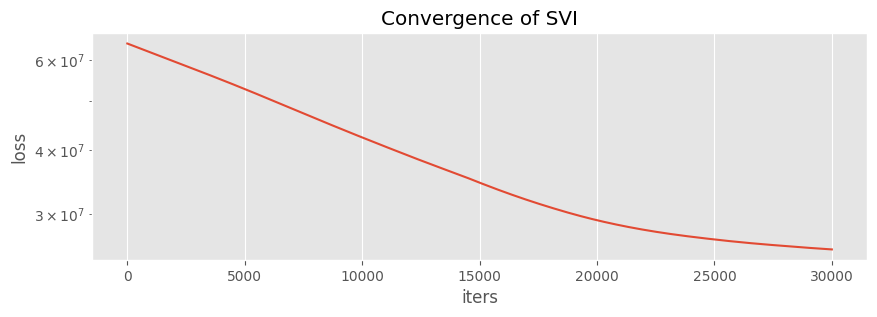

In [ ]:
from matplotlib import pyplot
%matplotlib inline

pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

**Model evaluation**

With a model trained by the trainset, the model is expected to be used to make prediction on the testset for evaluation. To do this, the classifier is built to predict the testset based on the discrete inference. Effect handlers of *trace*, *replay* and *infer_discrete* in Pyro is used here to build the classfier and read out the cluster assignment results from the model. The trace hanlder here records the relationships amongst different pyro primitives. Each node in the trace includes the name, input and output value of the site. [4]


[4] Trace, https://docs.pyro.ai/en/dev/poutine.html#trace

In [ ]:
guide_trace = poutine.trace(guide).get_trace(data)  # record the globals
trained_model = poutine.replay(gmm, trace=guide_trace)  # replay the globals

def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature, first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    print(trace)
    return trace.nodes["assignment"]["value"], trace.nodes["weights_scale"]["value"], trace.nodes["weights"]["value"], trace.nodes["locs"]["value"], trace.nodes["scale"]["value"]

print(classifier(X_test_torch.to(device)))

(tensor([2, 1, 1,  ..., 1, 0, 1]), tensor(729.7757, grad_fn=<ExpandBackward>), tensor([0.0146, 0.7612, 0.0608, 0.1529, 0.0105], grad_fn=<ExpandBackward>), tensor([[ 4.2932e-02,  1.7861e-01,  7.7845e-01,  3.9433e-03,  2.4885e-04,
         -4.8459e-07,  9.3262e-03,  1.5516e-07,  3.4648e-06,  4.9192e-04,
          4.2726e-06,  4.7585e-07,  2.4551e-04,  2.2382e-07,  1.5921e-02,
          1.7771e-07,  7.1147e-03, -3.0896e-06,  2.4553e-04,  4.6018e-08,
          3.6817e-03,  6.3758e-03,  2.7716e-02, -1.4012e-06,  1.3018e-06,
          2.4419e-03, -4.4476e-06, -3.0413e-07,  2.9072e-06, -2.5973e-05,
         -5.7947e-07,  8.6816e-07, -3.4143e-07,  2.8861e-06,  1.9106e-06,
         -5.9825e-07, -9.5059e-07, -4.5949e-07, -8.2517e-07, -7.5052e-07,
          2.6028e-04,  2.4556e-04,  2.9806e-03,  7.7746e-01, -2.3430e-05,
          2.1504e-05,  7.3786e-04, -9.1034e-01,  4.7700e-02,  1.2418e-06,
         -5.1001e-09, -1.3486e-07,  2.4571e-04,  5.1407e-02,  2.4805e-04,
         -2.5127e-06,  2.4538e-

In [ ]:
y_pred, y_weights_scale, y_weights, y_locs, y_scale = classifier(X_test_torch.to(device))
print(y_pred)

tensor([2, 1, 1,  ..., 1, 0, 1])


**Prediction results**

Detach the prediction results from GPU and make a general evalution on the accuracy by comparing the labels between the testset and prediction results. 

The accuracy shows an accuracy of 0.76 which is a bit lower but similar to the accuracy got from the notebook GMM (K=5) where the model is not tuned with hyperprior.

In [ ]:
y_pred = y_pred.detach().cpu().numpy() 
# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_pred == y_test) / len(y_test))

Accuracy: 0.7602757668127262


By taking a closer look at the prediction results for each cluster, with this hyperprior added in the GMM, the detection capability can be improved by detecting more type of attacks in the dataset. Compared with the model in the notebook GMM (K=5) where no data point is clustered to component 2 & 4, now with this modified model, a small number of data points can be clustered correctly to the component 2 & 4. This means that those type of attacks with small number of samples in the dataset can also be labeled in this unspervised model. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.06      0.11     33238
           1       0.97      0.94      0.95    132908
           2       0.08      0.56      0.14      1424
           3       0.01      0.55      0.02       384
           4       0.01      0.21      0.02        14

    accuracy                           0.76    167968
   macro avg       0.40      0.47      0.25    167968
weighted avg       0.95      0.76      0.78    167968



**Clustering parameters**

Below presents the parameters fitted for the GMM model trained in Pyro. The weights show that most of the data gathered in the component 1 and other four compnents have the similar weights. 

In [ ]:
y_weights

tensor([0.0146, 0.7612, 0.0608, 0.1529, 0.0105], grad_fn=<ExpandBackward>)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


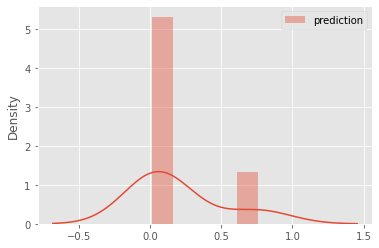

In [ ]:
sns.distplot(y_weights.cpu().detach().numpy(), label="prediction")
plt.legend()
plt.show()

The plot below is the density estimate and histogram of the mean values for the Gaussian distributions modeled for the samples for each component. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


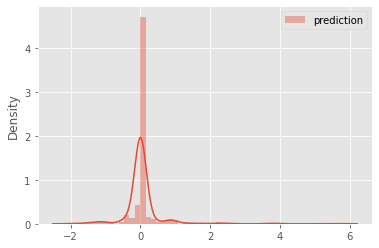

In [ ]:
sns.distplot(y_locs.cpu().detach().numpy(), label="prediction")
plt.legend()
plt.show()

To clearly compare the mixture model, the density estimate and histogram is drawn for both the real case (blue) and predicted case (red). In general, they show a similar pattern, but the predictions present some deviations from the real case. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


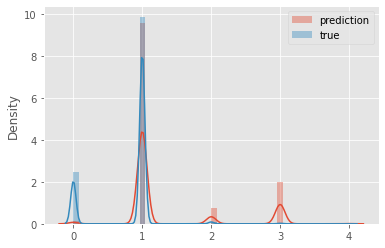

In [ ]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_test, label="true")
plt.legend()
plt.show()